In [1]:
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
import dccp
import pandas as pd
from itertools import product

In [2]:
np.random.seed(0)

df = pd.read_csv('../edge_withDistancesAndRadii.csv')  # Edge list with distances and r1+r2 columns
rdf = pd.read_csv('../all brain volumes.csv')  # CSV with radius info for nodes

In [3]:
nodes = np.unique(df['n1'].tolist() + df['n2'].tolist())
n = len(nodes)

In [4]:
## define the matrix of distances between nodes. It is symmetric
rij = np.zeros((n,n))  # Distance matrix
rij[rij<1.e-6] = 1.e-6
Rij = np.zeros((n,n))  # R1+R2 combined radii (min distance) matrix
Iij = np.zeros((n,n))  # Intensity matrix

ids = [0 for x in range(n)]  # List to lookup ids later

for i1 in range(n):
    for i2 in range(n):
        if i1 == i2: continue
        tempdf = df[(df['n1']==nodes[i1])&(df['n2']==nodes[i2])]
        if tempdf.index.size > 1:
            print("two edges for (%s,%s). only one will be stored. drop the duplicate and run again"%(nodes[i1],nodes[i2]))
            #raise(Exception("please drup the duplicate and run again"))
        elif tempdf.index.size == 1:
            rij[i1,i2] = tempdf['distance']
            Rij[i1,i2] = tempdf['R1+R2']
            Iij[i1,i2] = tempdf['intensity']
            ids[i1] = tempdf['n1'].iloc[0]
## symmetrize the tensors
rij = (rij + rij.transpose())/2.  # Distance matrix		
Rij = (Rij + Rij.transpose())/2.  # R1+R2 combined radii (min distance) matrix
Iij = (Iij + Iij.transpose())/2.  # Intensity matrix
Iij[Iij<1] = 1
Rij[Rij<1e-6] = 1e-6
Iij = Iij / 1000  # Scale intensities to kind of match distances

In [5]:
r = []  # Create ordered list with radii to match the nodes in and intensities
for node in ids:
    r.append(rdf.loc[rdf['ID'] == node]['Radius (mm)'].iloc[0])

In [6]:
c = cvx.Variable((n, 3))  # c is [n] sets of 3D coordinates
dists = [[0 for x in range(n)] for y in range(n)]
constr = []
for i in range(n):
    for j in range(n):
        if i == j:
            continue
        # Calculate the distance between two spheres
        dists[i][j] = cvx.norm(cvx.vec(c[i, :] - c[j, :]), 2)
        # The distance between 2 spheres (represented as 3D coords) must be greater than the radii of the two spheres combined
        constr.append(dists[i][j] >= r[i] + r[j])
        #print("%i, %i: dist= >= %f" % (i, j, r[i] + r[j]))
d = cvx.multiply(cvx.bmat(dists), Iij)

In [69]:
#prob = cvx.Problem(cvx.Minimize(cvx.norm(cvx.abs(d), 1)), constr)  # Minimize the greatest distance from the origin
prob = cvx.Problem(cvx.Minimize(cvx.multiply(cvx.norm(cvx.abs(d), 1), n * n)), constr)  # Minimize the greatest distance from the origin
prob.solve(method="dccp", solver="ECOS", ep=1e-2, max_slack=1e-2)
#print(d.value)

D:\Apps\anaconda3\envs\cvxpy\lib\site-packages\cvxpy\problems\problem.py:1126: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


(112495.74180682478,
 2.1324979115526388e-08,
 [array([[-0.05195805, -0.83162228,  0.44896683],
         [ 0.28353578, -0.12916893, -0.73499731],
         [-0.07902777,  0.55365408, -0.33083666],
         [-0.30360157,  0.15959364, -0.72756854],
         [ 0.71891109,  0.32323836, -0.07721987],
         [-0.92500669, -0.35730767, -0.3806844 ],
         [-0.17990552,  1.0593412 ,  0.64721501],
         [-0.71589813,  0.18252488,  0.40811641],
         [ 0.51386706, -0.41548466,  0.50455892],
         [ 0.82617398,  0.305538  ,  0.980533  ],
         [ 1.07438061, -0.88063108,  0.28391725],
         [ 0.81486961, -0.47533925, -0.07937951],
         [ 0.46345542, -1.09584012,  0.32419068],
         [-0.93368783,  0.27717598,  0.96489656],
         [ 0.20770835,  0.13733584,  0.4778287 ],
         [-0.12584248,  1.20679214, -0.49237103],
         [-0.22847214, -0.19018256,  0.98830645],
         [ 1.06328087, -0.36505216, -0.73489761],
         [ 0.36626812,  0.68712878, -1.01272361],
    

In [86]:
import pickle
with open('save_c.file', 'wb') as f:
    pickle.dump(c, f)

Variable((26, 3))

In [7]:
import pickle
with open('save_c.file', 'rb') as f:
    c = pickle.load(f)

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
# plot
fig = plt.figure(figsize=(20, 20))
ax = fig.gca(projection='3d')
ax.set_aspect('auto')
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
for i in range(n):
    colors = "b"
    if i == 3:
        colors = "r"
    elif i == 9:
        colors = "g"
    elif i == 8:
        colors = "y"
    else:
        colors = "b"
    ax.plot_surface(
        c[i, 0].value + r[i] * np.cos(u) * np.sin(v), c[i, 1].value + r[i] * np.sin(u) * np.sin(v), c[i, 2].value + r[i] * np.cos(v), color=colors
    )
plt.show()

<IPython.core.display.Javascript object>

In [25]:
rij_opt = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        if i == j:
            continue
        # Calculate the distance between two spheres
        rij_opt[i][j] = cvx.norm(cvx.vec(c[i, :] - c[j, :]), 2).value

In [26]:
pd.DataFrame(rij_opt)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.000000,1.416957,1.589911,1.558868,1.484862,1.294415,1.905627,1.212839,0.704570,1.531931,...,0.856440,1.692034,2.148966,1.331842,0.985380,0.803811,2.718778,1.413472,1.775521,0.655889
1,1.416957,0.000000,0.872379,0.654346,0.909338,1.279906,1.880916,1.550074,1.292876,1.851073,...,1.798791,0.814643,0.866209,1.792775,0.855759,0.863927,1.880649,0.816899,1.446501,1.662889
2,1.589911,0.872379,0.000000,0.602589,0.868400,1.244193,1.105659,1.043740,1.410191,1.612651,...,1.521764,1.520577,0.825272,1.487310,1.550104,0.822990,1.432451,1.279562,0.867527,1.621338
3,1.558868,0.654346,0.602589,0.000000,1.222810,0.879579,1.647688,1.208427,1.586540,2.053120,...,1.752773,1.464129,0.899073,1.384798,1.301417,0.795833,1.920894,0.735488,0.840370,1.536404
4,1.484862,0.909338,0.868400,1.222810,0.000000,1.804910,1.369133,1.521193,0.962404,1.063325,...,1.515415,1.012361,1.063927,2.032686,1.361000,1.061645,1.308245,1.635992,1.689226,1.837149
5,1.294415,1.279906,1.244193,0.879579,1.804910,0.000000,1.902274,0.978444,1.690384,2.314932,...,1.545065,2.019607,1.776995,0.705059,1.396806,0.819912,2.676337,0.759567,0.864449,0.955283
6,1.905627,1.880916,1.105659,1.647688,1.369133,1.902274,0.000000,1.055113,1.636088,1.300583,...,1.296153,2.341932,1.786685,1.689292,2.332564,1.427761,1.545504,2.238528,1.343440,1.850303
7,1.212839,1.550074,1.043740,1.208427,1.521193,0.978444,1.055113,0.000000,1.370853,1.649479,...,0.844462,2.184445,1.855935,0.657591,1.761251,0.772444,2.268026,1.526525,0.816981,0.894877
8,0.704570,1.292876,1.410191,1.586540,0.962404,1.690384,1.636088,1.370853,0.000000,0.918673,...,0.914243,1.356706,1.881406,1.759174,1.095622,0.916993,2.207194,1.673795,1.905763,1.245124
9,1.531931,1.851073,1.612651,2.053120,1.063325,2.314932,1.300583,1.649479,0.918673,0.000000,...,1.165366,1.857044,2.080912,2.230307,1.949416,1.525184,1.830949,2.395901,2.198686,1.897308


In [27]:
pd.DataFrame(rij)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.000001,3.446520,1.776345,2.215852,2.122357,0.433705,1.438923,0.531507,1.145644,3.073386,...,0.693542,2.614460,2.915150,0.825772,1.885444,1.750600,1.934373,1.089312,1.336600,0.050000
1,3.446520,0.000001,3.173594,4.904131,3.205636,3.702567,2.519444,3.069853,3.547675,2.807597,...,3.905752,3.206883,2.866217,3.718521,2.291593,4.297848,2.440266,3.196326,3.633979,3.487263
2,1.776345,3.173594,0.000001,3.429490,0.366879,1.718168,0.850941,1.767173,1.225928,1.545865,...,1.808867,0.965194,1.408865,1.426499,1.008415,1.438958,2.061553,0.695414,1.426359,1.767173
3,2.215852,4.904131,3.429490,0.000001,3.786608,2.436411,3.113599,2.159282,3.205074,4.895886,...,1.790810,4.394246,4.778085,2.062498,3.814040,3.406259,2.653262,2.933360,2.068454,2.209638
4,2.122357,3.205636,0.366879,3.786608,0.000001,2.042278,1.107113,2.115869,1.451516,1.244387,...,2.168363,0.620484,1.110901,1.786253,1.053423,1.579684,2.315038,1.035085,1.762186,2.113504
5,0.433705,3.702567,1.718168,2.436411,2.042278,0.000001,1.582466,0.943716,0.854751,3.025492,...,0.772593,2.506970,2.847350,0.879659,1.928419,1.382932,2.292880,1.035616,1.480000,0.394462
6,1.438923,2.519444,0.850941,3.113599,1.107113,1.582466,0.000001,1.210785,1.395708,1.849811,...,1.654116,1.554252,1.753283,1.340373,0.760658,1.972486,1.336600,0.760066,1.305756,1.453616
7,0.531507,3.069853,1.767173,2.159282,2.115869,0.943716,1.210785,0.000001,1.473092,3.000033,...,0.908020,2.621622,2.871515,0.933488,1.766182,2.120637,1.425938,1.163658,1.205404,0.570088
8,1.145644,3.547675,1.225928,3.205074,1.451516,0.854751,1.395708,1.473092,0.000001,2.334138,...,1.424254,1.792456,2.134385,1.280391,1.444784,0.870115,2.531660,0.744379,1.751856,1.124722
9,3.073386,2.807597,1.545865,4.895886,1.244387,3.025492,1.849811,3.000033,2.334138,0.000001,...,3.290122,0.739256,0.221359,2.932883,1.298769,2.581879,2.932388,2.081850,2.895514,3.077207


In [28]:
r = rij[0,1]/rij_opt[0,1]
for i, j in product(range(n),range(n)):
	if i>=j: continue
	print("d[%d,%d]: %1.2f(true) %1.2f(sol.)"%(i,j,rij[i,j], rij_opt[i,j]*r))
	

df['opt. distance'] = df.index.size*[0]
for i1 in range(n):
	for i2 in range(n):
		if i1 == i2: continue
		tempdf = df[(df['n1']==nodes[i1])&(df['n2']==nodes[i2])]
		if tempdf.index.size > 1:
			print("two edges for (%s,%s). only one will be stored. drop the duplicate and run again"%(nodes[i1],nodes[i2]))
			#raise(Exception("please drup the duplicate and run again"))
		elif tempdf.index.size == 1:
			df['opt. distance'][(df['n1']==nodes[i1])&(df['n2']==nodes[i2])] = r*rij_opt[i1,i2]

	
	
fig, ax = plt.subplots()
ax.scatter(df['distance'],df['opt. distance'],alpha=0.2)
ax.set_xlim(-2,8)
ax.set_ylim(-2,16)
# ax.set_xlabel(r'$r_{ij}$ (true)')
# ax.set_ylabel(r'$r_{ij}$ (optimal solution)')
plt.xlabel(r'$Distance_{ij}$ (true)', fontsize=18)
plt.ylabel(r'$Distance_{ij}$ (optimal solution)', fontsize=18)
plt.title('Optimal Model Arrangement vs. True Distance', fontsize=18)
plt.show()
fig.savefig('rij_true_vs_OptimalSolution.png')	
	
	
	
fig, ax = plt.subplots()
ax.scatter(df['opt. distance']-df['distance'],df['intensity'],color='k',alpha=0.4)
ax.set_xlabel(r'$\Delta r_{ij}$')
ax.set_ylabel(r'intensity')
plt.show()	

_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
D:\Apps\anaconda3\envs\cvxpy\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
D:\Apps\anaconda3\envs\cvxpy\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
D:\Apps\anaconda3\envs\cvxpy\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
df['opt. distance']

0      3.430407
1      2.451957
2      2.325047
3      2.582280
4      2.112244
         ...   
644    3.037577
645    3.086037
646    6.153622
647    4.794279
648    5.281170
Name: opt. distance, Length: 649, dtype: float64

In [13]:
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import dccp

np.random.seed(0)
n = 10
r = np.linspace(1, 5, n)

c = cvx.Variable((n, 3))  # c is a [n] sets of 3D coordinates
dists = [[0 for x in range(n)] for y in range(n)]
intens = np.ones((10,10))
intens[3][9] = 40
intens[3][8] = 0.001
#intens[6][9] = 1000
constr = []
for i in range(n):
    for j in range(n):
        if i == j:
            continue
        # Calculate the distance between two spheres
        dists[i][j] = cvx.norm(cvx.vec(c[i, :] - c[j, :]), 2)
        # The distance between 2 spheres (represented as 3D coords) must be greater than the radii of the two spheres combined
        constr.append(dists[i][j] >= r[i] + r[j])
        #print("%i, %i: dist= >= %f" % (i, j, r[i] + r[j]))
d = cvx.multiply(cvx.bmat(dists), intens)
#prob = cvx.Problem(cvx.Minimize(cvx.norm(cvx.abs(d), 1)), constr)  # Minimize the greatest distance from the origin
prob = cvx.Problem(cvx.Minimize(cvx.norm(d, 1)), constr)  # Minimize the greatest distance from the origin
prob.solve(method="dccp", solver="MOSEK", ep=1e-2, max_slack=1e-2)

(355.9999997598534,
 3.8593043187704834e-08,
 [array([[ 0.97991653, -3.94077015, -4.4170234 ],
         [ 4.45867093,  1.78696941, -4.29626112],
         [ 6.65835824,  1.40549613, -1.07127878],
         [ 0.37179457,  0.3902634 , -7.31349715],
         [ 3.03733217, -7.15810967,  0.1729402 ],
         [ 4.77089423,  6.32771711, -2.19168988],
         [-3.07446516, -7.21478637, -3.68858168],
         [-3.48641576,  5.72222406, -6.17360549],
         [ 7.3332933 , -3.82700403, -4.78387854],
         [ 0.        ,  0.        ,  0.        ]])],
 'Converged')

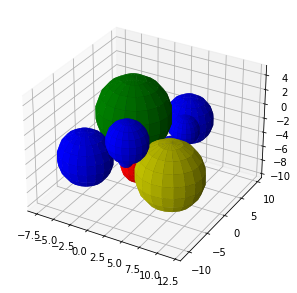

In [14]:
# plot
fig = plt.figure(figsize=(5, 5))
ax = fig.gca(projection='3d')
ax.set_aspect('auto')
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
for i in range(n):
    colors = "b"
    if i == 3:
        colors = "r"
    elif i == 9:
        colors = "g"
    elif i == 8:
        colors = "y"
    else:
        colors = "b"
    ax.plot_surface(
        c[i, 0].value + r[i] * np.cos(u) * np.sin(v), c[i, 1].value + r[i] * np.sin(u) * np.sin(v), c[i, 2].value + r[i] * np.cos(v), color=colors
    )
# def rotate(angle):
#     ax.view_init(azim=angle)
# rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0,362,2),interval=100)
# rot_animation.save('./rotation2.gif', dpi=80, writer='imagemagick')
plt.show()

In [2]:
import pandas as pd
pd.DataFrame(d.value)

,0,1,2,3,4,5,6,7,8,9
0,0.000000,7.992546,7.799427,5.099326,4.188505,10.989214,5.161084,10.158198,5.555795,10.605399
1,7.992546,0.000000,7.275611,4.816909,8.180074,4.859654,10.989897,9.974241,6.000247,6.638342
2,7.799427,7.275611,0.000000,6.509480,11.061057,5.983833,6.700115,11.631252,6.444705,13.504539
3,5.099326,4.816909,6.509480,0.000000,6.300277,7.869022,7.543561,6.453984,6888.887654,0.227807
4,4.188505,8.180074,11.061057,6.300277,0.000000,12.476069,9.246718,10.231980,7.333666,7.864535
5,10.989214,4.859654,5.983833,7.869022,12.476069,0.000000,12.105556,12.558077,7.778085,11.031271
6,5.161084,10.989897,6.700115,7.543561,9.246718,12.105556,0.000000,11.495129,8.222525,15.297028
7,10.158198,9.974241,11.631252,6.453984,10.231980,12.558077,11.495129,0.000000,13.324917,12.519943
8,5.555795,6.000247,6.444705,6.888888,7.333666,7.778085,8.222525,13.324917,0.000000,9.555912
9,10.605399,6.638342,13.504539,9.112276,7.864535,11.031271,15.297028,12.519943,9.555912,0.000000


In [8]:
cvx.norm(cvx.vec(c[3, :] - c[9, :]), 2).value

9.112275729394845

In [16]:
abs(c[0].value[0])

0.979916529205353